# **Phishing URL detection: clustering**

**RQ1:** What characteristics provide the greatest discriminatory information for identifying phishing sites compared to legitimate ones?  

**RQ2:** Do synthetic data generated by Large Language Models preserve the same statistical properties as real data?

**RQ3:** What are the main differences between synthetic data generated by LLMs and real data in regression and clustering contexts?

**RQ4:** Can the features generated by LLMs be mapped to known statistical distributions?

<br>

**Author:** Raffaele Aurucci

## **Reading filtered dataset**

In [1]:
download.file("https://drive.google.com/uc?id=1Hq5AkkiOBiPLmPMEzLbgPj83Hs_lzUnY&export=download", "Phishing_URL_Dataset_3_Filtered.csv")

In [6]:
df <- read.csv('Phishing_URL_Dataset_3_Filtered.csv', sep = ",")

In [7]:
str(df)

'data.frame':	20153 obs. of  21 variables:
 $ URLLength            : int  462 379 285 437 22 221 318 397 21 473 ...
 $ DomainLength         : int  14 14 14 14 14 11 11 13 13 13 ...
 $ TLDEncoding          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ NoOfLettersInURL     : int  298 227 171 152 0 145 201 245 0 307 ...
 $ NoOfDegitsInURL      : int  87 81 54 264 11 29 58 88 10 100 ...
 $ NoOfSpecialCharsInURL: int  54 48 37 14 4 24 36 57 4 59 ...
 $ IsHTTPS              : int  1 1 1 0 0 1 1 0 0 1 ...
 $ LineOfCode           : int  2 2 11 242 17 11 2 2 11 125 ...
 $ LargestLineLength    : int  1638 1638 564 446 234 493 1638 1638 257 52977 ...
 $ HasTitle             : int  1 1 1 1 1 1 1 1 1 1 ...
 $ NoOfReference        : int  0 0 1 1 2 1 0 0 1 7 ...
 $ DomainTitleMatchScore: num  0 0 0 0 0 0 0 0 0 0 ...
 $ URLTitleMatchScore   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ HasFavicon           : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Robots               : int  0 0 0 0 0 0 0 0 0 0 ...
 $ IsResponsive         : int  1 1

In [44]:
set.seed(42)

## **Distance Matrix**

In [4]:
if(!require(cluster)) install.packages('cluster')

library(cluster)

Loading required package: cluster



### Z-score normalization

In [9]:
df_X <- df[, -ncol(df)]

# Exclude binary features to the scaling
exclude_columns <- c(7, 10, 14, 15, 16, 18, 19, 20)

df_to_scale <- df_X[, -exclude_columns]

df_scaled <- scale(df_to_scale)

# Combined binary and continuous fratures
df_normalized <- cbind(df_scaled, df_X[, exclude_columns])

# Converting in data frame
df_X <- as.data.frame(df_normalized)

The **Gower Method** is a technique used to compute the distance matrix of a dataset, which can handle mixed types of variables (e.g., numerical and categorical data).

In [10]:
# Convert in factors binary features
df_X[c(13:20)] <- lapply(df_X[c(13:20)], as.factor)

# Compute distance matrix with 'gower' method
distance_matrix <- daisy(df_X, metric = "gower")

## **Total Non-Homogeneity Matrix**

### The statistical measure of heterogeneity (**trace**) is calculated to assess how homogeneous the data are.

In [11]:
# Substitue factors in numeric features
df_X[c(13:20)] <- df[, c(7, 10, 14, 15, 16, 18, 19, 20)]

# Variance/covariance matrix
WI <- cov(df_X[,-1])

n <- nrow(df_X[, -1])

# Non-Homogeneity Matrix
HI <- (n-1)*WI

trHI <- sum(diag(HI))
trHI

[1] 255641.6

## **Hierarchical Clustering: Complete Linkage**

In [37]:
hls <- hclust(distance_matrix, method = "complete")
str(hls)

List of 7
 $ merge      : int [1:20152, 1:2] -95 -18820 -18824 -121 -483 -122 -123 -325 -137 -530 ...
 $ height     : num [1:20152] 0 0 0 0 0 0 0 0 0 0 ...
 $ order      : int [1:20153] 12453 15216 15139 15140 15192 15183 15214 12439 15151 12320 ...
 $ labels     : NULL
 $ method     : chr "complete"
 $ call       : language hclust(d = distance_matrix, method = "complete")
 $ dist.method: NULL
 - attr(*, "class")= chr "hclust"


### Screeplot

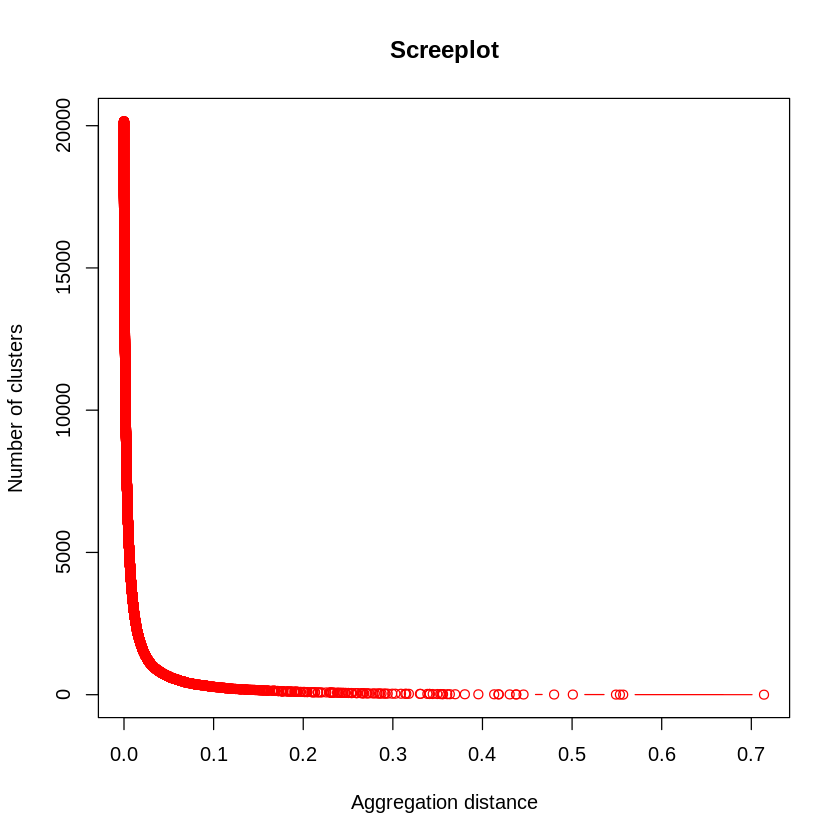

In [38]:
plot(c(0, hls$height), seq(20153,1), type = "b", main = "Screeplot",
     xlab = "Aggregation distance", ylab = "Number of clusters",
     col = "red")

### **Cutree:** cut dendograms in two sets

In [39]:
# Cut dendograms in two sets
cut <- cutree (hls , k = 2, h = NULL)

# Number of elemnts in each cluster
num <- table (cut)

num

cut
    1     2 
 9812 10341 

In [40]:
# List of labels of clusters
cut_list <- list(cut)

# The sample variance of the data columns is calculated based on cluster labels
agvar <- aggregate(df_X, cut_list, var)[, -1]

# Trace of first cluster
trH1 <-(num [[1]] -1) * sum(agvar [1, ])
if(is.na(trH1))
  trH1 <- 0

# Trace of second cluster
trH2 <-(num [[2]] -1) *sum(agvar [2, ])
if(is.na(trH2))
  trH2 <- 0

# Within
sum <- trH1 + trH2
paste('Within:', sum)

# Between
trB <- trHI - sum
paste('Between', trB)

[1] "Within: 230714.29804792"

[1] "Between 24927.3093554445"

In [41]:
# Phishing/Legitimate in each cluster
df_with_cluster <- data.frame(df, Cluster = cut)

cluster_count <- table(df_with_cluster$Cluster, df_with_cluster$label)

colnames(cluster_count) <- c("phishing", "legitimate")

cluster_count

   
    phishing legitimate
  1     9562        250
  2      513       9828

### Silhouette Method

In [42]:
# List of mean silhouette's coefficients
silhouette_means <- numeric()

for (k in 2:10) {

  cut <- cutree(hls, k = k)

  # Count num of element in each cluster
  num <- table(cut)
  print(num)

  # Silhouette's coefficients
  sil <- silhouette(cut, distance_matrix)

  # Mean silhouette's coefficients
  silhouette_mean <- mean(sil[, 3])
  silhouette_means[k] <- silhouette_mean

  cat("k =", k, "- Silhouette mean:", silhouette_mean, "\n\n")
}

print(silhouette_means[2:10])

cut
    1     2 
 9812 10341 
k = 2 - Silhouette mean: 0.4876214 

cut
   1    2    3 
9812 2541 7800 
k = 3 - Silhouette mean: 0.4196514 

cut
   1    2    3    4 
5650 4162 2541 7800 
k = 4 - Silhouette mean: 0.3044584 

cut
   1    2    3    4    5 
5650 4162   57 2484 7800 
k = 5 - Silhouette mean: 0.2893291 

cut
   1    2    3    4    5    6 
4653 4162  997   57 2484 7800 
k = 6 - Silhouette mean: 0.2926593 

cut
   1    2    3    4    5    6    7 
4653 4162  997   57 2484 7246  554 
k = 7 - Silhouette mean: 0.2058748 

cut
   1    2    3    4    5    6    7    8 
4653 4162  174   57 2484 7246  823  554 
k = 8 - Silhouette mean: 0.200389 

cut
   1    2    3    4    5    6    7    8    9 
3196 4162  174   57 2484 7246  823 1457  554 
k = 9 - Silhouette mean: 0.2472332 

cut
   1    2    3    4    5    6    7    8    9   10 
3196 4162  174   57 2484 1916  823 1457 5330  554 
k = 10 - Silhouette mean: 0.2590894 

[1] 0.4876214 0.4196514 0.3044584 0.2893291 0.2926593 0.2058748 0.200

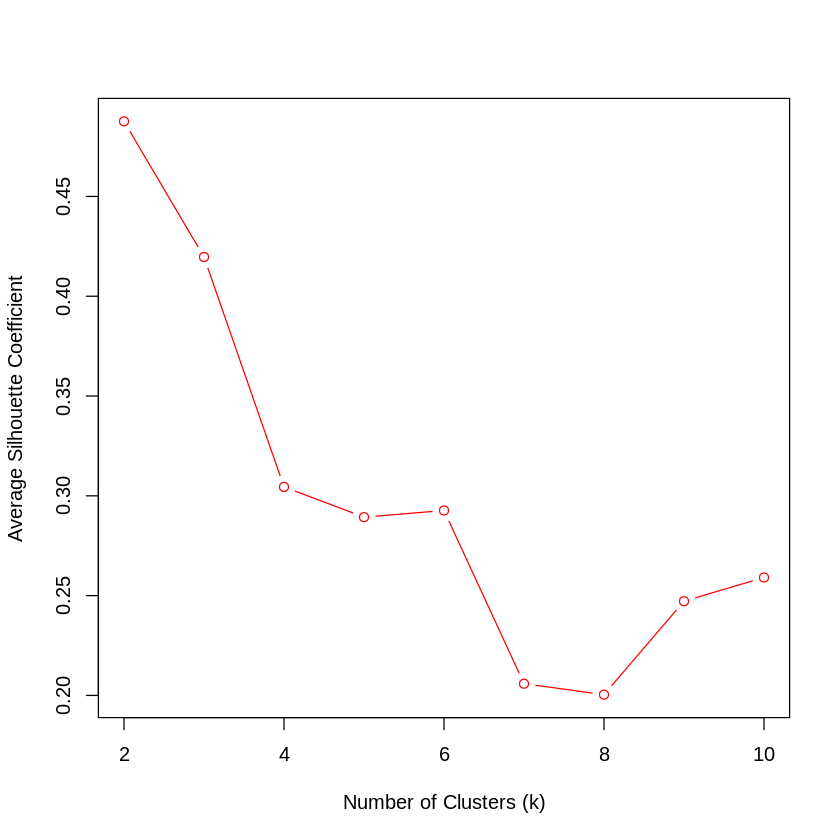

In [43]:
# Plot mean silhouette's coefficients
plot(2:10, silhouette_means[2:10], type = "b", xlab = "Number of Clusters (k)",
    ylab = "Average Silhouette Coefficient", col='red')

## **Hierarchical Clustering: Centroid Linkage**

In [45]:
# Squared of distance matrix
d2 <- distance_matrix^2

hls <- hclust(d2, method = "centroid")

str(hls)

List of 7
 $ merge      : int [1:20152, 1:2] -95 -18820 -18824 -121 -483 -122 -123 -325 -137 -530 ...
 $ height     : num [1:20152] 0 0 0 0 0 0 0 0 0 0 ...
 $ order      : int [1:20153] 18639 4281 15126 5887 9178 4598 4183 11038 13671 14456 ...
 $ labels     : NULL
 $ method     : chr "centroid"
 $ call       : language hclust(d = d2, method = "centroid")
 $ dist.method: NULL
 - attr(*, "class")= chr "hclust"


### Screeplot

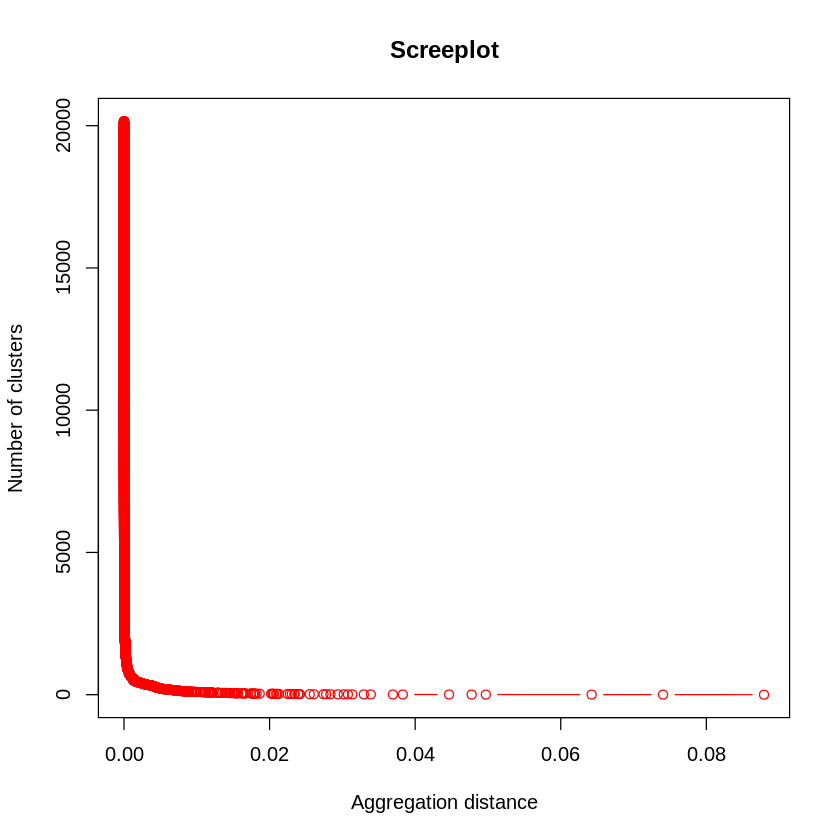

In [46]:
plot(c(0, hls$height), seq(20153,1), type = "b", main = "Screeplot",
     xlab = "Aggregation distance", ylab = "Number of clusters",
     col = "red")

### **Cutree:** cut dendograms in two sets

In [47]:
# Cut dendograms in two sets
cut <- cutree (hls , k = 2, h = NULL)

# Number of elemnts in each cluster
num <- table (cut)

num

cut
    1     2 
 9820 10333 

In [48]:
# List of labels of clusters
cut_list <- list(cut)

# The sample variance of the data columns is calculated based on cluster labels
agvar <- aggregate(df_X, cut_list, var)[, -1]

# Trace of first cluster
trH1 <-(num [[1]] -1) * sum(agvar [1, ])
if(is.na(trH1))
  trH1 <- 0

# Trace of second cluster
trH2 <-(num [[2]] -1) *sum(agvar [2, ])
if(is.na(trH2))
  trH2 <- 0

# Within
sum <- trH1 + trH2
paste('Within:', sum)

# Between
trB <- trHI - sum
paste('Between', trB)

[1] "Within: 231723.057449663"

[1] "Between 23918.5499537014"

In [49]:
# Phishing/Legitimate in each cluster
df_with_cluster <- data.frame(df, Cluster = cut)

cluster_count <- table(df_with_cluster$Cluster, df_with_cluster$label)

colnames(cluster_count) <- c("phishing", "legitimate")

cluster_count

   
    phishing legitimate
  1     9620        200
  2      455       9878

### Silhouette Method

In [50]:
# List of mean silhouette's coefficients
silhouette_means <- numeric()

for (k in 2:10) {

  cut <- cutree(hls, k = k)

  # Count num of element in each cluster
  num <- table(cut)
  print(num)

  # Silhouette's coefficients
  sil <- silhouette(cut, distance_matrix)

  # Mean silhouette's coefficients
  silhouette_mean <- mean(sil[, 3])
  silhouette_means[k] <- silhouette_mean

  cat("k =", k, "- Silhouette mean:", silhouette_mean, "\n\n")
}

print(silhouette_means[2:10])

cut
    1     2 
 9820 10333 
k = 2 - Silhouette mean: 0.4918804 

cut
    1     2     3 
 9802    18 10333 
k = 3 - Silhouette mean: 0.452724 

cut
    1     2     3     4 
 9802    14 10333     4 
k = 4 - Silhouette mean: 0.4262998 

cut
    1     2     3     4     5 
 9792    14 10333     4    10 
k = 5 - Silhouette mean: 0.3880428 

cut
    1     2     3     4     5     6 
 9761    14 10333    31     4    10 
k = 6 - Silhouette mean: 0.3493044 

cut
    1     2     3     4     5     6     7 
 9760    14 10333    31     4     1    10 
k = 7 - Silhouette mean: 0.2908451 

cut
    1     2     3     4     5     6     7     8 
 9760    14 10330    31     4     3     1    10 
k = 8 - Silhouette mean: 0.2257594 

cut
   1    2    3    4    5    6    7    8    9 
9760   14 7821 2509   31    4    3    1   10 
k = 9 - Silhouette mean: 0.2876649 

cut
   1    2    3    4    5    6    7    8    9   10 
8265   14 1495 7821 2509   31    4    3    1   10 
k = 10 - Silhouette mean: 0.3118772 

[1]

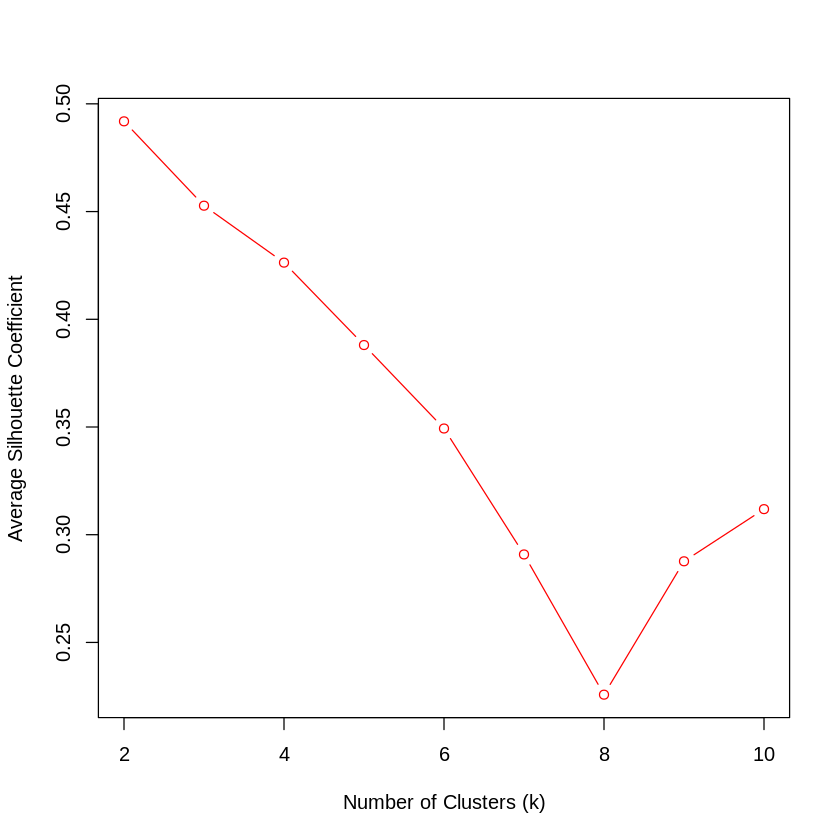

In [51]:
# Plot mean silhouette's coefficients
plot(2:10, silhouette_means[2:10], type = "b", xlab = "Number of Clusters (k)",
    ylab = "Average Silhouette Coefficient", col='red')

## **Hierarchical Clustering: Average Linkage**

In [59]:
hls <- hclust(distance_matrix, method = "average")
str(hls)

List of 7
 $ merge      : int [1:20152, 1:2] -95 -18820 -18824 -121 -483 -122 -123 -325 -137 -530 ...
 $ height     : num [1:20152] 0 0 0 0 0 0 0 0 0 0 ...
 $ order      : int [1:20153] 16204 17353 16861 16953 12764 12787 15249 17862 13341 13393 ...
 $ labels     : NULL
 $ method     : chr "average"
 $ call       : language hclust(d = distance_matrix, method = "average")
 $ dist.method: NULL
 - attr(*, "class")= chr "hclust"


### Screeplot

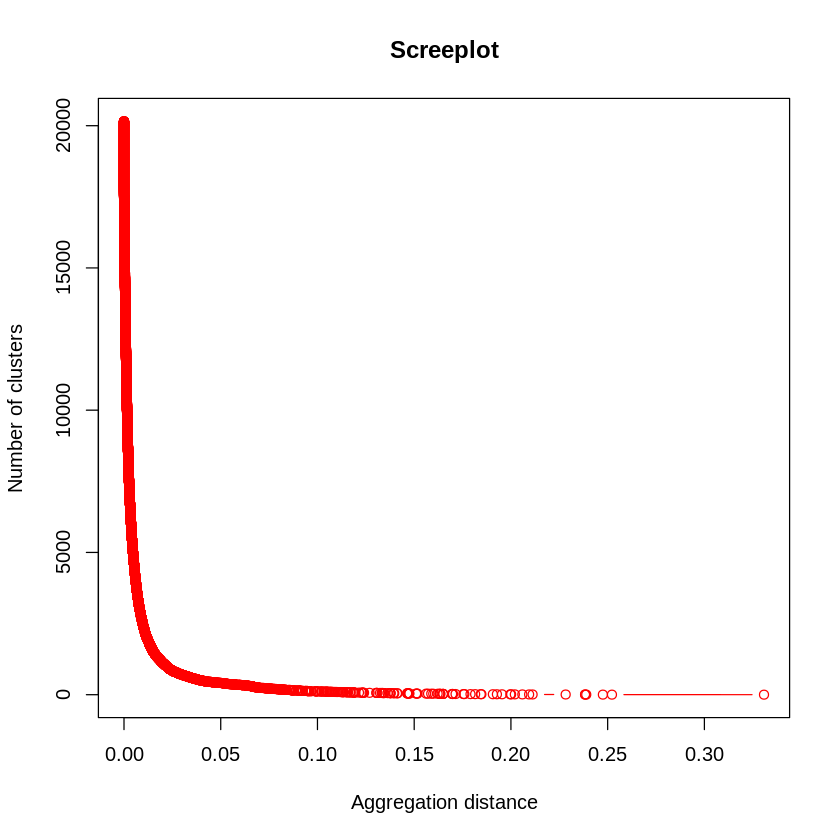

In [60]:
plot(c(0, hls$height), seq(20153,1), type = "b", main = "Screeplot",
     xlab = "Aggregation distance", ylab = "Number of clusters",
     col = "red")

### **Cutree:** cut dendograms in two sets

In [61]:
# Cut dendograms in two sets
cut <- cutree (hls , k = 2, h = NULL)

# Number of elemnts in each cluster
num <- table (cut)

num

cut
    1     2 
 9257 10896 

In [62]:
# List of labels of clusters
cut_list <- list(cut)

# The sample variance of the data columns is calculated based on cluster labels
agvar <- aggregate(df_X, cut_list, var)[, -1]

# Trace of first cluster
trH1 <-(num [[1]] -1) * sum(agvar [1, ])
if(is.na(trH1))
  trH1 <- 0

# Trace of second cluster
trH2 <-(num [[2]] -1) *sum(agvar [2, ])
if(is.na(trH2))
  trH2 <- 0

# Within
sum <- trH1 + trH2
paste('Within:', sum)

# Between
trB <- trHI - sum
paste('Between', trB)

[1] "Within: 235727.045198966"

[1] "Between 19914.5622043981"

In [63]:
# Phishing/Legitimate in each cluster
df_with_cluster <- data.frame(df, Cluster = cut)

cluster_count <- table(df_with_cluster$Cluster, df_with_cluster$label)

colnames(cluster_count) <- c("phishing", "legitimate")

cluster_count

   
    phishing legitimate
  1     9157        100
  2      918       9978

### Silhouette Method

In [64]:
# List of mean silhouette's coefficients
silhouette_means <- numeric()

for (k in 2:10) {

  cut <- cutree(hls, k = k)

  # Count num of element in each cluster
  num <- table(cut)
  print(num)

  # Silhouette's coefficients
  sil <- silhouette(cut, distance_matrix)

  # Mean silhouette's coefficients
  silhouette_mean <- mean(sil[, 3])
  silhouette_means[k] <- silhouette_mean

  cat("k =", k, "- Silhouette mean:", silhouette_mean, "\n\n")
}

print(silhouette_means[2:10])

cut
    1     2 
 9257 10896 
k = 2 - Silhouette mean: 0.4697987 

cut
    1     2     3 
   53  9204 10896 
k = 3 - Silhouette mean: 0.3926409 

cut
   1    2    3    4 
  53 9204 3138 7758 
k = 4 - Silhouette mean: 0.3900707 

cut
   1    2    3    4    5 
  39 9204 3138 7758   14 
k = 5 - Silhouette mean: 0.3772813 

cut
   1    2    3    4    5    6 
  39 9145 3138 7758   14   59 
k = 6 - Silhouette mean: 0.3469644 

cut
   1    2    3    4    5    6    7 
  39 9121 3138 7758   14   24   59 
k = 7 - Silhouette mean: 0.3220894 

cut
   1    2    3    4    5    6    7    8 
  39 9075   46 3138 7758   14   24   59 
k = 8 - Silhouette mean: 0.3125427 

cut
   1    2    3    4    5    6    7    8    9 
  39 9075   46 3138 7758   14   24   56    3 
k = 9 - Silhouette mean: 0.2989936 

cut
   1    2    3    4    5    6    7    8    9   10 
  36 9075   46 3138 7758   14   24   56    3    3 
k = 10 - Silhouette mean: 0.2965234 

[1] 0.4697987 0.3926409 0.3900707 0.3772813 0.3469644 0.322089

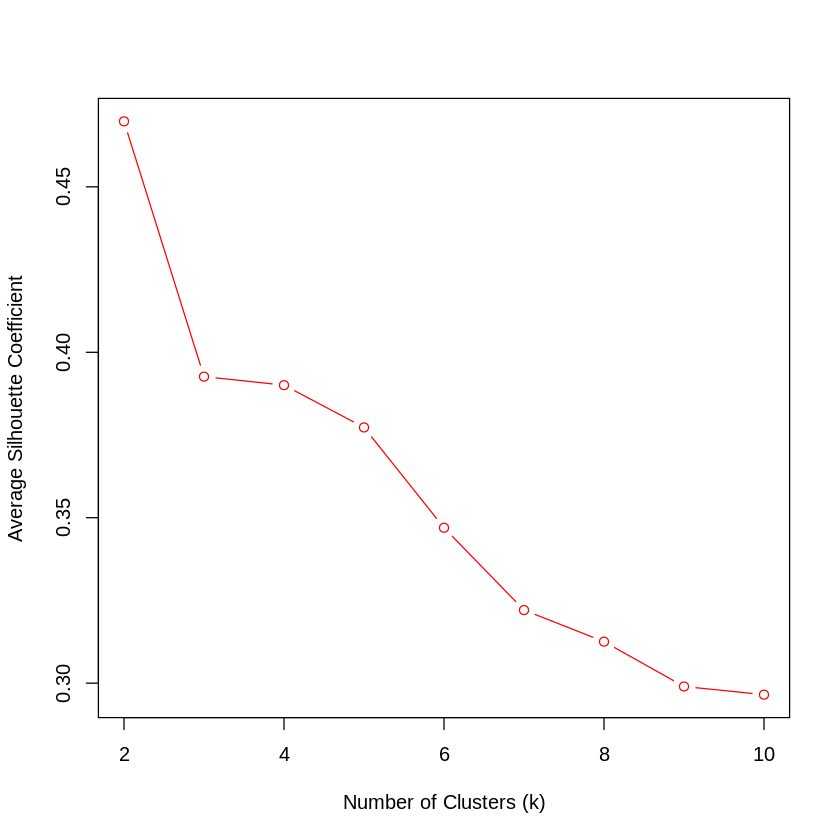

In [65]:
# Plot mean silhouette's coefficients
plot(2:10, silhouette_means[2:10], type = "b", xlab = "Number of Clusters (k)",
    ylab = "Average Silhouette Coefficient", col='red')

## **Hierarchical Clustering: Single Linkage**

In [52]:
hls <- hclust(distance_matrix, method = "single")
str(hls)

List of 7
 $ merge      : int [1:20152, 1:2] -95 -18820 -18824 -121 -483 -122 -123 -325 -137 -530 ...
 $ height     : num [1:20152] 0 0 0 0 0 0 0 0 0 0 ...
 $ order      : int [1:20153] 8036 2810 6992 18639 9135 73 66 67 47 58 ...
 $ labels     : NULL
 $ method     : chr "single"
 $ call       : language hclust(d = distance_matrix, method = "single")
 $ dist.method: NULL
 - attr(*, "class")= chr "hclust"


### Screeplot

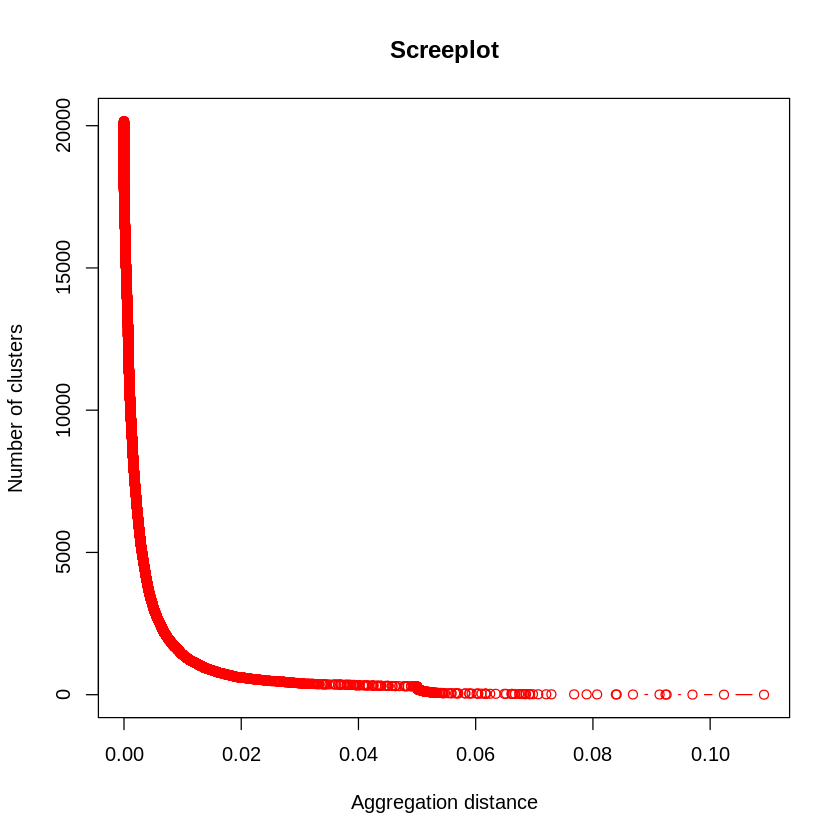

In [53]:
plot(c(0, hls$height), seq(20153,1), type = "b", main = "Screeplot",
     xlab = "Aggregation distance", ylab = "Number of clusters",
     col = "red")

### **Cutree:** cut dendograms in two sets

In [54]:
# Cut dendograms in two sets
cut <- cutree (hls , k = 2, h = NULL)

# Number of elemnts in each cluster
num <- table (cut)

num

cut
    1     2 
20150     3 

In [55]:
# List of labels of clusters
cut_list <- list(cut)

# The sample variance of the data columns is calculated based on cluster labels
agvar <- aggregate(df_X, cut_list, var)[, -1]

# Trace of first cluster
trH1 <-(num [[1]] -1) * sum(agvar [1, ])
if(is.na(trH1))
  trH1 <- 0

# Trace of second cluster
trH2 <-(num [[2]] -1) *sum(agvar [2, ])
if(is.na(trH2))
  trH2 <- 0

# Within
sum <- trH1 + trH2
paste('Within:', sum)

# Between
trB <- trHI - sum
paste('Between', trB)

[1] "Within: 272617.975921286"

[1] "Between -16976.3685179216"

In [56]:
# Phishing/Legitimate in each cluster
df_with_cluster <- data.frame(df, Cluster = cut)

cluster_count <- table(df_with_cluster$Cluster, df_with_cluster$label)

colnames(cluster_count) <- c("phishing", "legitimate")

cluster_count

   
    phishing legitimate
  1    10072      10078
  2        3          0

### Silhouette Method

In [57]:
# List of mean silhouette's coefficients
silhouette_means <- numeric()

for (k in 2:10) {

  cut <- cutree(hls, k = k)

  # Count num of element in each cluster
  num <- table(cut)
  print(num)

  # Silhouette's coefficients
  sil <- silhouette(cut, distance_matrix)

  # Mean silhouette's coefficients
  silhouette_mean <- mean(sil[, 3])
  silhouette_means[k] <- silhouette_mean

  cat("k =", k, "- Silhouette mean:", silhouette_mean, "\n\n")
}

print(silhouette_means[2:10])

cut
    1     2 
20150     3 
k = 2 - Silhouette mean: 0.2537906 

cut
    1     2     3 
20149     3     1 
k = 3 - Silhouette mean: 0.0651333 

cut
    1     2     3     4 
20137    12     3     1 
k = 4 - Silhouette mean: 0.03872982 

cut
    1     2     3     4     5 
20136    12     1     3     1 
k = 5 - Silhouette mean: -0.009907602 

cut
    1     2     3     4     5     6 
20135    12     1     3     1     1 
k = 6 - Silhouette mean: -0.02778267 

cut
    1     2     3     4     5     6     7 
20134    12     1     3     1     1     1 
k = 7 - Silhouette mean: -0.1092226 

cut
    1     2     3     4     5     6     7     8 
20133    12     1     3     1     1     1     1 
k = 8 - Silhouette mean: -0.1236335 

cut
    1     2     3     4     5     6     7     8     9 
20132    12     1     1     3     1     1     1     1 
k = 9 - Silhouette mean: -0.1446014 

cut
    1     2     3     4     5     6     7     8     9    10 
20131    12     1     1     3     1     1     1     1 

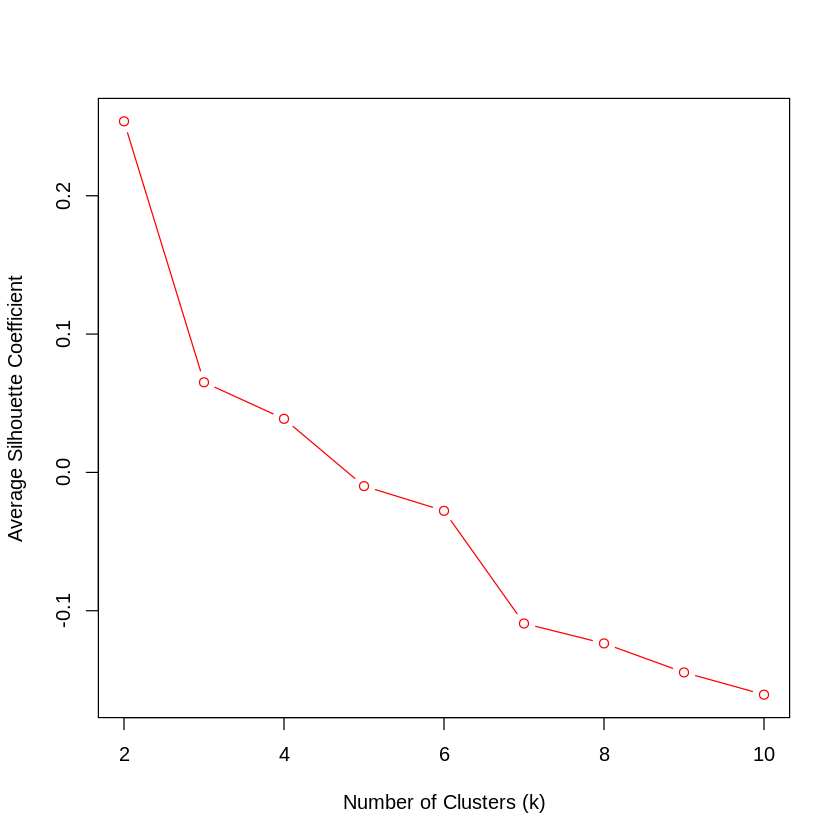

In [58]:
# Plot mean silhouette's coefficients
plot(2:10, silhouette_means[2:10], type = "b", xlab = "Number of Clusters (k)",
    ylab = "Average Silhouette Coefficient", col='red')

## **Hierarchical Clustering: Median Linkage**

In [66]:
hls <- hclust(distance_matrix, method = "median")
str(hls)

List of 7
 $ merge      : int [1:20152, 1:2] -95 -18820 -18824 -121 -483 -122 -123 -325 -137 -530 ...
 $ height     : num [1:20152] 0 0 0 0 0 0 0 0 0 0 ...
 $ order      : int [1:20153] 6573 1540 5928 19253 19009 1166 8036 2810 6992 9135 ...
 $ labels     : NULL
 $ method     : chr "median"
 $ call       : language hclust(d = distance_matrix, method = "median")
 $ dist.method: NULL
 - attr(*, "class")= chr "hclust"


### Screeplot

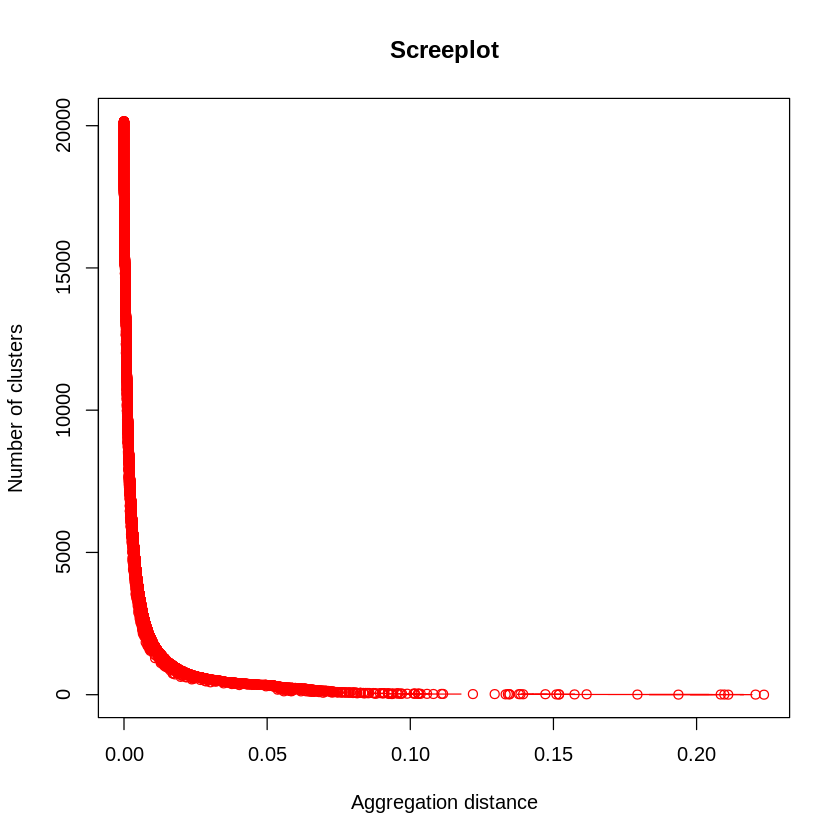

In [67]:
plot(c(0, hls$height), seq(20153,1), type = "b", main = "Screeplot",
     xlab = "Aggregation distance", ylab = "Number of clusters",
     col = "red")

### **Cutree:** cut dendograms in two sets

In [68]:
# Cut dendograms in two sets
cut <- cutree (hls , k = 2, h = NULL)

# Number of elemnts in each cluster
num <- table (cut)

num

cut
    1     2 
20152     1 

In [69]:
# List of labels of clusters
cut_list <- list(cut)

# The sample variance of the data columns is calculated based on cluster labels
agvar <- aggregate(df_X, cut_list, var)[, -1]

# Trace of first cluster
trH1 <-(num [[1]] -1) * sum(agvar [1, ])
if(is.na(trH1))
  trH1 <- 0

# Trace of second cluster
trH2 <-(num [[2]] -1) *sum(agvar [2, ])
if(is.na(trH2))
  trH2 <- 0

# Within
sum <- trH1 + trH2
paste('Within:', sum)

# Between
trB <- trHI - sum
paste('Between', trB)

[1] "Within: 263346.153421972"

[1] "Between -7704.54601860803"

In [70]:
# Phishing/Legitimate in each cluster
df_with_cluster <- data.frame(df, Cluster = cut)

cluster_count <- table(df_with_cluster$Cluster, df_with_cluster$label)

colnames(cluster_count) <- c("phishing", "legitimate")

cluster_count

   
    phishing legitimate
  1    10075      10077
  2        0          1

### Silhouette Method

In [71]:
# List of mean silhouette's coefficients
silhouette_means <- numeric()

for (k in 2:10) {

  cut <- cutree(hls, k = k)

  # Count num of element in each cluster
  num <- table(cut)
  print(num)

  # Silhouette's coefficients
  sil <- silhouette(cut, distance_matrix)

  # Mean silhouette's coefficients
  silhouette_mean <- mean(sil[, 3])
  silhouette_means[k] <- silhouette_mean

  cat("k =", k, "- Silhouette mean:", silhouette_mean, "\n\n")
}

print(silhouette_means[2:10])

cut
    1     2 
20152     1 
k = 2 - Silhouette mean: 0.1392751 

cut
    1     2     3 
20149     3     1 
k = 3 - Silhouette mean: 0.003661294 

cut
    1     2     3     4 
20148     3     1     1 
k = 4 - Silhouette mean: -0.1071773 

cut
    1     2     3     4     5 
20146     2     3     1     1 
k = 5 - Silhouette mean: -0.1187243 

cut
    1     2     3     4     5     6 
20146     2     1     2     1     1 
k = 6 - Silhouette mean: -0.173032 

cut
    1     2     3     4     5     6     7 
20146     2     1     1     1     1     1 
k = 7 - Silhouette mean: -0.2176006 

cut
    1     2     3     4     5     6     7     8 
20146     1     1     1     1     1     1     1 
k = 8 - Silhouette mean: -0.2578358 

cut
    1     2     3     4     5     6     7     8     9 
20145     1     1     1     1     1     1     1     1 
k = 9 - Silhouette mean: -0.275838 

cut
    1     2     3     4     5     6     7     8     9    10 
20142     1     1     1     3     1     1     1     1    

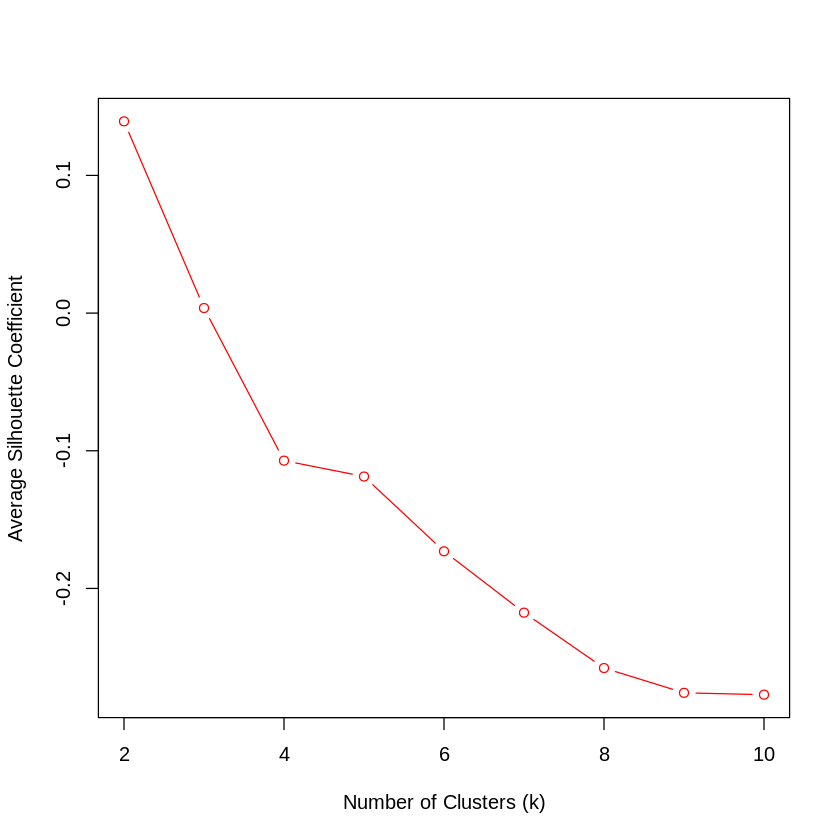

In [72]:
# Plot mean silhouette's coefficients
plot(2:10, silhouette_means[2:10], type = "b", xlab = "Number of Clusters (k)",
    ylab = "Average Silhouette Coefficient", col='red')